In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

from keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def training_data_preprocessing(in_path):

    raw_train = pd.read_csv(in_path)

    # normalize x by 255, encode y category with one-hot encoding
    x_train_total = np.array([ row.split() for row in raw_train['feature'] ], dtype='float') / 255
    y_train_total = raw_train['label'].values

    # reshape data format channels_last for cnn model
    x_train_total = x_train_total.reshape( (x_train_total.shape[0], 48, 48, 1) )

    return x_train_total, y_train_total


def split_validate(train_x, train_y, validate_n, seed=None):

        # val_n
        data_n = train_x.shape[0]
        if isinstance(validate_n, float):
            val_n = int(data_n*validate_n)
        elif isinstance(validate_n, int):
            val_n = int(validate_n)

        # mask
        mask = np.ones(data_n, dtype=bool)

        sample_idx = np.arange(data_n)
        if seed:
            rng = np.random.RandomState(int(seed))
            rng.shuffle(sample_idx)
        else:
            np.random.shuffle(sample_idx)
        sample_idx = sample_idx[:val_n]

        mask[sample_idx] = False

        # train, validate
        x_train, y_train = train_x[mask], train_y[mask]
        x_val, y_val = train_x[~mask], train_y[~mask]

        print ("Training data x shape: {}, Training ground truth y shape: {}".format(x_train.shape, y_train.shape))
        print ("Validation data x shape: {}, Validation ground truth y shape: {}".format(x_val.shape, y_val.shape))

        return x_train, y_train, x_val, y_val



# util function to convert a tensor into a valid image
def deprocessImage(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    # print(x.shape)
    return x


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
KTF.set_session(sess)

In [4]:
x_train_total, y_train_total = training_data_preprocessing("../data/train.csv")
x_train, y_train, x_val, y_val = split_validate(x_train_total, y_train_total, 0.1, seed=1234)

cnn_model = load_model("../model/best/val_0.1_seed_1234_epoch_2000_batch_64_opt_adam_cnn_filter_112_elu_1.0_dnn_unit_896_elu_1.0_0722-0.7052.hdf5")
y_pre = cnn_model.predict(x_val.reshape(x_val.shape[0], 48, 48, 1)).argmax(axis=1)

Training data x shape: (25839, 48, 48, 1), Training ground truth y shape: (25839,)
Validation data x shape: (2870, 48, 48, 1), Validation ground truth y shape: (2870,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
y_pre.shape

(2870,)

In [6]:
print_n = 20
for i in range(y_val.shape[0]): 
    if (y_val[i] == 4) and (y_pre[i] == 6):
        print (i)
        print_n -= 1
    if (print_n == 0):
        break

46
69
73
92
141
154
167
175
221
236
252
273
278
284
302
321
395
423
438
502


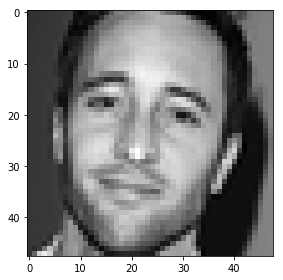

In [8]:
plt.figure()
plt.imshow(x_val[742].reshape(48, 48), cmap='gray')
plt.tight_layout()
fig = plt.gcf()

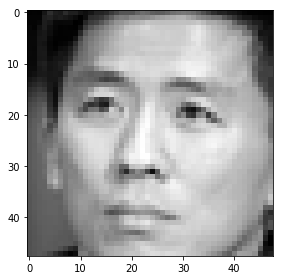

In [9]:
plt.figure()
plt.imshow(x_val[154].reshape(48, 48), cmap='gray')
plt.tight_layout()
fig = plt.gcf()